# Exploring the Weather in Athens

In this project we will explore the weather in Athens over a period of more than 50 years. 

---

> Chalkiopoulos Georgios, Electrical and Computer Engineer NTUA <br>
> Data Science postgraduate Student <br> 
> gchalkiopoulos@aueb.gr

# Intro 

There are 5 sections in this project. The first one focuses on abtaining and preparing the data and the remaining 4 at creating a graph while commenting on the results. 

In Brief the sections are:
* Obtain the data
* Deviation of Summer Temperatures (Graph)
* Evolution of Daily Temperatures (Graph)
* Extreme Temperature Events (Graph)
* Precipitation (Graph)


# Imports

In [1]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import itertools

from calendar import monthrange
import datetime

# magic word for producing visualizations in notebook
%matplotlib inline

# Define plotting parameters
font_dict={'fontsize' : '12', 'fontweight': 'bold'}

# Section 1: Obtain the Data

We will work with data covering the period from 1955 to 2020. The data will be obtained from two sources:

* Data downloaded from the [National Oceanic and Atmospheric Administration's National Centers for Environmental Information](https://www.ncdc.noaa.gov/cdo-web/) and in [particular](https://www.ncdc.noaa.gov/cdo-web/search). 

* As we are focusing on Athens, we will use the data from the Hellinikon weather station and we will concentrate on the average daily temperature and precipitation.

* Explore the completeness of the data. **What data are missing?**

* To fill in any missing data we will use an alternative dataset available from [hellenicdataservice](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f); this dataset covers only the period from 2010-2019.

In order to download the data, from the National Oceanic and Atmospheric Administration's National Centers for Environmental Information, a form was filled and the data was sent trough email. For the sake of simplicity the csv file has been added to the corresponding repo and we will access it directly through that. 

In [2]:
# read the National Oceanic and Atmospheric Administration's National Centers for Environmental Information
df = pd.read_csv('./ncdc_data.csv', parse_dates=['DATE'])

In [3]:
# fetch the first lines
df.head()

,STATION,NAME,DATE,PRCP,SNWD,TAVG,TMAX,TMIN
0,GR000016716,"HELLINIKON, GR",1955-01-01,0.00,NaN,NaN,65.0,50.0
1,GR000016716,"HELLINIKON, GR",1955-01-02,0.08,NaN,NaN,58.0,45.0
2,GR000016716,"HELLINIKON, GR",1955-01-03,0.00,NaN,NaN,60.0,49.0
3,GR000016716,"HELLINIKON, GR",1955-01-04,0.00,NaN,NaN,66.0,45.0
4,GR000016716,"HELLINIKON, GR",1955-01-05,0.00,NaN,NaN,64.0,47.0


In [4]:
df.dtypes

STATION            object
NAME               object
DATE       datetime64[ns]
PRCP              float64
SNWD              float64
TAVG              float64
TMAX              float64
TMIN              float64
dtype: object

### **Data exploration**
In order to get a better understading of the data, we used the [Documention](https://www1.ncdc.noaa.gov/pub/data/cdo/documentation/GHCND_documentation.pdf), and looked for the specific columns that we have in our dataset. Below is a brief description of the data:

| Attribute | Description |
| ------------- |:-------------:| 
| STATION | *(17 characters) is the station identification code*. In our case since we selected only one station this should be unique |
| NAME | *max 50 characters) is the name of the station (usually city/airport name).* Again only one station was selected so this one is HELLINIKON, GR |
| DATE | *the year of the record (4 digits) followed by month (2 digits) and day (2 digits).* |
| PRCP | *Precipitation (mm or inches as per user preference, inches to hundredths on Daily Form pdf file)* |
| SNWD | *Snow depth (mm or inches as per user preference, inches on Daily Form pdf file)* |
| TAVG | *Average Temperature* |
| TMAX | *Maximum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file* |
| TMIN | *Minimum temperature (Fahrenheit or Celsius as per user preference, Fahrenheit to tenths on Daily Form pdf file* |

<br>
> In our case all values are in Inches and Fahrenheit.

* Let's exprolre the data

In [5]:
# get info about the dataframe
df.describe()

,PRCP,SNWD,TAVG,TMAX,TMIN
count,22773.000000,30.000000,20940.000000,22307.000000,22418.000000
mean,0.039799,6.006667,64.884575,72.225669,58.047596
std,0.182426,13.950922,12.471614,13.309235,11.631550
min,0.000000,0.400000,28.000000,34.000000,24.000000
25%,0.000000,0.400000,55.000000,62.000000,49.000000
50%,0.000000,0.800000,64.000000,71.000000,58.000000
75%,0.000000,1.600000,76.000000,84.000000,68.000000
max,5.590000,48.800000,95.000000,108.000000,87.000000


In [6]:
df.shape

(23251, 8)

* We ll start by converting the Temperature and Precipitation columns to Celcius and mm respectively.

In [7]:
# Convert F to C
df[['TAVG', 'TMAX', 'TMIN']] = df[['TAVG', 'TMAX', 'TMIN']].apply(lambda row: (row - 32) * 5/9)
df[['TAVG', 'TMAX', 'TMIN']].describe()

,TAVG,TMAX,TMIN
count,20940.000000,22307.000000,22418.000000
mean,18.269208,22.347594,14.470886
std,6.928674,7.394020,6.461972
min,-2.222222,1.111111,-4.444444
25%,12.777778,16.666667,9.444444
50%,17.777778,21.666667,14.444444
75%,24.444444,28.888889,20.000000
max,35.000000,42.222222,30.555556


In [8]:
# Convert inches to mm
df['PRCP'] = df['PRCP'] * 25.4
df['PRCP'].describe()

count    22773.000000
mean         1.010892
std          4.633631
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        141.986000
Name: PRCP, dtype: float64

### Missing Data

* First let's see how much data is missing, before deciding on how to handle missing values.

In [9]:
def return_missing_data(data, year=2030, first_half=True):
    """ Returns missing percentage of a given dataframe, ordered by column Name.
        INPUT:  a dataframe 
                the year we want to split the data 
                First_half should be true if we only want to fetch data until the provided date (based on the year). If True end date is excluded, else included.
        OUTPUT: Null values percentage in per column
    """

    if first_half:
        return ((data.loc[data['DATE'].dt.year < year].isnull().sum()/data.shape[0])*100).sort_index(ascending=True)
    else:
        return ((data.loc[data['DATE'].dt.year >= year].isnull().sum()/data.shape[0])*100).sort_index(ascending=True)

In [10]:
# Perform an assessment of what percentage of the data is missing in each column of the dataset.
return_missing_data(df)

DATE        0.000000
NAME        0.000000
PRCP        2.055826
SNWD       99.870973
STATION     0.000000
TAVG        9.939357
TMAX        4.060040
TMIN        3.582642
dtype: float64

* We know that we have data after 2010 available so we will split the data into two dataframes, before 2010 and after.

In [11]:
# split the df in two to see where the missing data is located

# Before 2010
return_missing_data(df, year=2010)

DATE        0.000000
NAME        0.000000
PRCP        1.496710
SNWD       86.336072
STATION     0.000000
TAVG        9.939357
TMAX        0.356974
TMIN        1.453701
dtype: float64

In [12]:
# After 2010
return_missing_data(df, year=2010, first_half=False)

DATE        0.000000
NAME        0.000000
PRCP        0.559116
SNWD       13.534902
STATION     0.000000
TAVG        0.000000
TMAX        3.703067
TMIN        2.128941
dtype: float64

* Where exactly the missing data located? <br>

Most of the missing data is located in the Snow Depth (SNWD) column which is of no interest for this analysis. We will, therefore, focus on the other columns.

We aobserve that the Tmax and Tmin is mostly missing after 2010, while the TAVG is missing for data before 2010. We 'll consider two courses of action:

1. Let's see if there extra data we have can fill the missing info after 2010.
2. We 'll make an assesment of the TAVG based on the TMAX and TMIN values. Our intuition says that we could take the average of the two and fill the TAVG. Let's test if the Hypothesis is correct

Finally, since most of the precipitation is missing for data before 2010, and the missing data is just a small percentage of the data, we might discard these rows.

## Download alternative dataset

In [13]:
# alternative dataset
df2 = pd.read_csv('https://data.hellenicdataservice.gr/dataset/d3b0d446-aaba-49a8-acce-e7c6f6f5d3b5/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748/download/athens.csv')
df2.head()

,2010-01-01,17.9,18.1,17.8,61.4,91,33,1003.6,1006.3,1002.0,0.2,4.0,WSW,12.7
0,2010-01-02,15.6,15.7,15.5,57.4,70,45,1005.2,1008.7,1001.5,0.0,6.8,WSW,20.7
1,2010-01-03,13.5,13.6,13.4,56.0,76,39,1011.7,1016.7,1008.6,0.0,5.0,WSW,15.4
2,2010-01-04,9.5,9.6,9.5,50.7,60,38,1021.3,1023.1,1016.8,0.0,4.3,NNE,11.0
3,2010-01-05,13.4,13.5,13.4,70.5,82,54,1018.7,1022.1,1015.5,0.0,7.9,S,19.8
4,2010-01-06,16.8,16.9,16.8,79.3,83,72,1012.9,1015.6,1011.1,0.0,15.2,S,34.3


The dataset from the Hellenic Data Service doesn't have any headers. From the [Website](https://data.hellenicdataservice.gr/dataset/66e1c19a-7b0e-456f-b465-b301a1130e3f/resource/a7c024b3-8606-4f08-93e2-2042f5bd6748) we read that: <br>
> "*Each line consists of 14 columns. First is the date of the parameters (YYYY-MM-DD). Next are the mean, maximum and minimum Humerature (°C). After that and in the same order we have 6 columns for relative humidity and atmospheric pressure (%, hPa). The tenth column is the daily rainfall (mm). In the last 3 columns we can see mean wind speed, dominant wind direction as well as wind gust (km/h).*"

In [14]:
col_names = ['DATE', 
    'Temp_mean', 'Temp_max', 'Temp_min', 
    'Hum_mean', 'Hum_max', 'Hum_min',
    'Press_mean', 'Press_max', 'Press_min',
    'Rain', 
    'Wind_Speed_mean', 'Wind_dir', 'Wind_Speed_max'
]
df2.columns = col_names
df2.head()

,DATE,Temp_mean,Temp_max,Temp_min,Hum_mean,Hum_max,Hum_min,Press_mean,Press_max,Press_min,Rain,Wind_Speed_mean,Wind_dir,Wind_Speed_max
0,2010-01-02,15.6,15.7,15.5,57.4,70,45,1005.2,1008.7,1001.5,0.0,6.8,WSW,20.7
1,2010-01-03,13.5,13.6,13.4,56.0,76,39,1011.7,1016.7,1008.6,0.0,5.0,WSW,15.4
2,2010-01-04,9.5,9.6,9.5,50.7,60,38,1021.3,1023.1,1016.8,0.0,4.3,NNE,11.0
3,2010-01-05,13.4,13.5,13.4,70.5,82,54,1018.7,1022.1,1015.5,0.0,7.9,S,19.8
4,2010-01-06,16.8,16.9,16.8,79.3,83,72,1012.9,1015.6,1011.1,0.0,15.2,S,34.3


* We know that the Temperature columns have some string values in them ('---'), thus we will replace those with NaN and also convert them to float.

In [15]:
# replace '---' with nan 
df2.replace('---', np.nan, inplace=True)

# Convert to float
df2[['Temp_mean','Temp_max','Temp_min']] = df2[['Temp_mean','Temp_max','Temp_min']].astype(float)

In [16]:
# convert the date to a datetime object
df2['DATE'] = df2.DATE.astype('datetime64[ns]')

In [17]:
df2.describe()

,Temp_mean,Temp_max,Temp_min,Hum_mean,Hum_max,Hum_min,Press_mean,Press_max,Press_min,Rain,Wind_Speed_mean,Wind_Speed_max
count,3648.000000,3648.000000,3648.000000,3651.000000,3651.000000,3651.000000,3651.000000,3651.000000,3651.000000,3651.00000,3651.000000,3651.000000
mean,19.443668,19.543969,19.345998,60.689729,75.155848,45.713503,1015.312380,1017.354259,1013.223035,1.25582,4.609860,11.954944
std,7.144573,7.155800,7.133719,12.753988,12.015063,13.018725,6.102371,5.994064,6.389216,4.99461,3.227916,6.312166
min,0.800000,0.900000,0.700000,26.300000,38.000000,13.000000,992.300000,999.400000,983.400000,0.00000,0.200000,2.000000
25%,13.700000,13.800000,13.600000,50.650000,67.000000,36.000000,1011.300000,1013.100000,1009.300000,0.00000,2.300000,7.500000
50%,18.900000,19.000000,18.800000,61.300000,77.000000,45.000000,1014.600000,1016.500000,1012.700000,0.00000,3.600000,10.300000
75%,25.800000,25.900000,25.700000,70.700000,85.000000,55.000000,1019.200000,1021.200000,1017.100000,0.00000,6.100000,15.100000
max,35.300000,35.500000,35.200000,90.100000,96.000000,85.000000,1037.100000,1039.400000,1036.300000,97.00000,23.200000,46.300000


In [18]:
 # Combine the two datasets into a new one.
 merged = pd.merge(df[['STATION', 'NAME', 'DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN']],
        df2[['DATE', 'Temp_mean', 'Temp_max', 'Temp_min', 'Rain']],
        on='DATE',
        how='outer')
merged.head()

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN,Temp_mean,Temp_max,Temp_min,Rain
0,GR000016716,"HELLINIKON, GR",1955-01-01,0.000,NaN,18.333333,10.000000,NaN,NaN,NaN,NaN
1,GR000016716,"HELLINIKON, GR",1955-01-02,2.032,NaN,14.444444,7.222222,NaN,NaN,NaN,NaN
2,GR000016716,"HELLINIKON, GR",1955-01-03,0.000,NaN,15.555556,9.444444,NaN,NaN,NaN,NaN
3,GR000016716,"HELLINIKON, GR",1955-01-04,0.000,NaN,18.888889,7.222222,NaN,NaN,NaN,NaN
4,GR000016716,"HELLINIKON, GR",1955-01-05,0.000,NaN,17.777778,8.333333,NaN,NaN,NaN,NaN


In [19]:
merged.loc[merged['DATE'].dt.year < 2010]

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN,Temp_mean,Temp_max,Temp_min,Rain
0,GR000016716,"HELLINIKON, GR",1955-01-01,0.000,NaN,18.333333,10.000000,NaN,NaN,NaN,NaN
1,GR000016716,"HELLINIKON, GR",1955-01-02,2.032,NaN,14.444444,7.222222,NaN,NaN,NaN,NaN
2,GR000016716,"HELLINIKON, GR",1955-01-03,0.000,NaN,15.555556,9.444444,NaN,NaN,NaN,NaN
3,GR000016716,"HELLINIKON, GR",1955-01-04,0.000,NaN,18.888889,7.222222,NaN,NaN,NaN,NaN
4,GR000016716,"HELLINIKON, GR",1955-01-05,0.000,NaN,17.777778,8.333333,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
20081,GR000016716,"HELLINIKON, GR",2009-12-27,0.000,17.777778,18.333333,15.000000,NaN,NaN,NaN,NaN
20082,GR000016716,"HELLINIKON, GR",2009-12-28,1.524,16.111111,NaN,NaN,NaN,NaN,NaN,NaN
20083,GR000016716,"HELLINIKON, GR",2009-12-29,0.000,13.888889,16.666667,NaN,NaN,NaN,NaN,NaN
20084,GR000016716,"HELLINIKON, GR",2009-12-30,0.000,13.333333,17.222222,8.888889,NaN,NaN,NaN,NaN


## 1. Fill missing values after 2010

* We ll start by adding any missing values after 2010 using the alternative dataset

In [20]:
# add missing values and convert to float
merged['TAVG'] = merged['TAVG'].fillna(merged['Temp_mean']).astype(float)
merged['TMAX'] = merged['TMAX'].fillna(merged['Temp_max']).astype(float)
merged['TMIN'] = merged['TMIN'].fillna(merged['Temp_min']).astype(float)
merged['PRCP'] = merged['PRCP'].fillna(merged['Rain']).astype(float)

In [21]:
# see missing data after the change
return_missing_data(merged, year=2010, first_half=False)

DATE         0.000000
NAME         3.538832
PRCP         0.120312
Rain         1.522569
STATION      3.538832
TAVG         0.004149
TMAX         0.174245
TMIN         0.199137
Temp_max     1.535015
Temp_mean    1.535015
Temp_min     1.535015
dtype: float64

* The missing data after 2010 looks much better. Only a small percentage is now missing, which can be discarded. Moreover the columns with info after 2010 are not needed so we can just drop them.

In [22]:
# Drop Columns containing data after 2010
merged.drop(['Temp_mean', 'Temp_max', 'Temp_min', 'Rain'], axis=1, inplace=True)
merged.columns


Index(['STATION', 'NAME', 'DATE', 'PRCP', 'TAVG', 'TMAX', 'TMIN'], dtype='object')

## 2. Fill missing the rest of the missing values <br>

Regarding the rest of the values we'll assume that the TAVG is the average of the Max and the Min. How accurate is this hypothesis? Let's find out. 

We will create a histogram of (actual) TAVG and add on top of that add the (calculated) average of TMAX and TMIN. 

In [23]:
print(f"The average of the difference between TMAX and TMIN is {((merged['TMAX']+merged['TMIN'])/2).mean():.2f} \
while the average temperature is {merged['TAVG'].mean():.2f}")

The average of the difference between TMAX and TMIN is 18.48 while the average temperature is 18.37


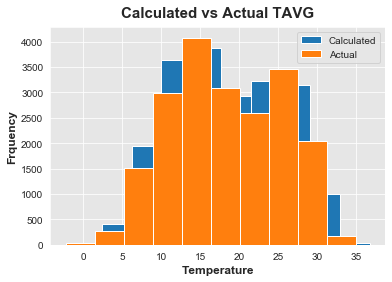

In [24]:
# PLot the calculated and actual TAVG
plt.rcParams.update({'figure.max_open_warning': 0})
sns.set_style("darkgrid", {"axes.facecolor": ".9"})
plt.hist((merged.dropna()['TMAX']+merged.dropna()['TMIN'])/2, label='Calculated')
plt.hist(merged.dropna()['TAVG'], label='Actual')
plt.title('Calculated vs Actual TAVG', 
            fontdict=font_dict,
            fontsize=15, 
            pad=10)
plt.xlabel('Temperature', fontdict=font_dict)
plt.ylabel('Frquency', fontdict=font_dict)
_ = plt.legend()


* We see that the calculated histogram has a shift to the right, comprated to the actual average temperatures. When it comes to temperatures, even one degree of increase/decrease can make a difference in the analysis. In order to avoid introducing Bias to the results we will just discard the records for which temperatures are missing. <br>


In [25]:
# Drop missing values of TMAX or TMIN and create a temp(erature) dataset to work on temperature investigation
temp = merged.dropna(subset=['TMAX', 'TMIN']).copy().drop('PRCP', axis=1)

*You may uncomment the following cell and run the report once more to see the impact of manually calculating the AVG temp for the missing values on the final results* 

In [26]:
# Uncomment Run the following cell if you want to see calculate the average temp based on the average of TMAX and TMIN

# # Add TAVG values
# temp['TAVG'].fillna((temp['TMAX']+temp['TMIN'])/2, inplace=True)
# return_missing_data(temp)

In [27]:
# Drop missing values of TMAX or TMIN and create a temp(erature) dataset to work on temperature investigation
temp.dropna(subset=['TAVG'], inplace=True)

<br><br><br>

# Section 2: Deviation of Summer Temperatures

The Hellenic National Meteorological Service has published a report on extreme weather events for 2020. The report is available at the following [link](http://www.hnms.gr/emy/en/pdf/2020_GRsignificantEVENT_en.pdf). In page 7 of the report there is a graph showing the mean summer temperature deviation from a baseline of 1971-2000.

We will create our own version of the graph, using a baseline of 1974-1999.<br>

First of all, now that the dataframe is ready to use, we will start by grouping the temperatures per year.


In [28]:
# group the temp dataset per year
grouped_temp = temp.loc[temp['DATE'].dt.month.isin([6,7,8])].groupby(temp['DATE'].dt.year).agg(['mean']).reset_index()

# calculate the 1974 - 1999 mean
baseline = grouped_temp['TAVG'].loc[(grouped_temp['DATE'] >= 1974) & (grouped_temp['DATE']  <= 1999)].mean()[0]
print(f'Baseline average temperature is {baseline:.2f}')

# find the AVG temp difference with the mean
grouped_temp['diff'] = grouped_temp['TAVG'] - baseline
grouped_temp['diff'].head()

Baseline average temperature is 26.23


0    1.871899
1    0.812603
2    0.389898
3    1.283618
4    1.372273
Name: diff, dtype: float64

* Plot the deviation of summer temperatures

In [29]:
# color pallete
colors = ['orange' if c >= 0 else 'blue' for c in grouped_temp['diff']]


In [30]:
# rolling average
grouped_temp['rolling'] = grouped_temp['diff'].rolling(10, min_periods=1).mean()

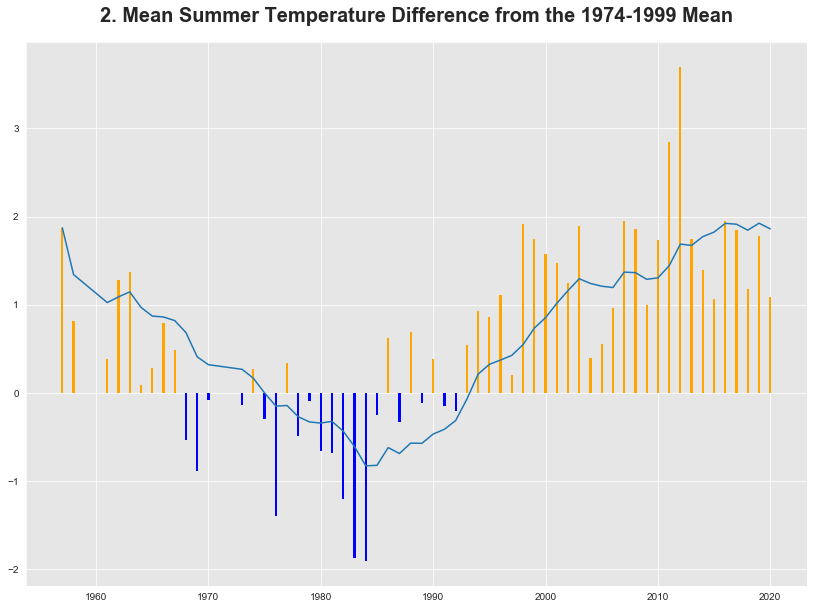

In [31]:
# plot the graph
plt.figure(figsize=(14,10))
plt.bar(grouped_temp['DATE'], grouped_temp['diff'], color=colors, width=0.2, linewidth=0)
plt.title('2. Mean Summer Temperature Difference from the 1974-1999 Mean',
            fontdict=font_dict,
            fontsize=20, 
            pad=20)
output = plt.plot(grouped_temp['DATE'], grouped_temp['rolling'])


## Analysis: Interpretation of the graph

Looking at the graph the first conclusion that can be made is that there is an increase in the average summer temperature for the past 20 years, compared to the baseline, which we determined to be the average summer temperatures from 1974-1999. 
Moreover, looking at the rolling average, it's clear that the trend is follows an increasing pattern



<br><br>

# Section 3: Evolution of Daily Temperatures

We will now get the average temperate for each year for the full period from 1955 to 2020. We will then create a plot showing the daily temperature for each year. The line corresponding to each year will be smoothed by using a 30 days rolling average. The lines are colored from light orange to dark orange, progressing through the years in ascending order.

On that plot we will overlay a line showing the average daily temperature for the baseline period of 1974-1999 (that is the black line). The line will also be smoothed usng a 30 Days rolling average. 


In [32]:
# break the date into Year, Month and Day
temp['Year'] = temp['DATE'].dt.year
temp['Month'] = temp['DATE'].dt.month
temp['Day'] = temp['DATE'].dt.day
temp.head()

,STATION,NAME,DATE,TAVG,TMAX,TMIN,Year,Month,Day
912,GR000016716,"HELLINIKON, GR",1957-07-01,22.222222,25.555556,18.333333,1957,7,1
913,GR000016716,"HELLINIKON, GR",1957-07-02,26.111111,32.777778,19.444444,1957,7,2
914,GR000016716,"HELLINIKON, GR",1957-07-03,25.555556,30.555556,21.111111,1957,7,3
915,GR000016716,"HELLINIKON, GR",1957-07-04,26.666667,32.777778,20.000000,1957,7,4
916,GR000016716,"HELLINIKON, GR",1957-07-05,28.333333,34.444444,22.222222,1957,7,5


* we will use pivoting in order to break the data per year. This way we will ensure that there will be a row for every month/day of each year.

In [33]:
temp_pivot = pd.pivot_table(temp, values = 'TAVG', 
                index = ['Month', 'Day'],  
                columns=[temp['DATE'].dt.year])
temp_pivot

DATE            1957       1958       1961       1962       1963       1964  \
Month Day                                                                     
1     1          NaN  12.222222  12.222222  12.777778  15.000000   9.444444   
      2          NaN  11.666667  12.222222  13.888889  13.888889   9.444444   
      3          NaN  12.222222  13.333333  16.666667  13.333333   7.777778   
      4          NaN  10.555556  13.888889  11.666667  16.666667  10.555556   
      5          NaN   8.333333  15.555556   8.888889  15.000000   8.888889   
...              ...        ...        ...        ...        ...        ...   
12    27   10.000000  13.333333  13.888889  16.111111  10.555556  13.888889   
      28   10.000000  12.222222  16.666667  14.444444  12.222222  12.222222   
      29   11.666667  13.333333  17.222222  13.333333   8.888889  11.666667   
      30   15.555556  11.111111  13.888889  16.666667   8.333333  12.777778   
      31   15.555556   8.888889  13.888889  16.666667   8.888889  13.888889   

DATE            1965       1966       1967       1968  ...       2011  \
Month Day                                              ...              
1     1    11.111111  13.333333  11.666667  15.000000  ...  10.000000   
      2    11.666667  12.222222  11.111111  15.000000  ...  11.666667   
      3    14.444444  13.333333  13.333333  14.444444  ...  11.111111   
      4    15.000000  12.777778  15.000000  11.666667  ...  10.000000   
      5    11.666667   7.222222  13.888889   9.444444  ...   9.444444   
...              ...        ...        ...        ...  ...        ...   
12    27   15.000000   8.333333  16.111111  11.666667  ...   8.888889   
      28   15.000000   8.888889  15.555556  15.000000  ...   9.444444   
      29   16.666667  10.555556  13.333333  12.222222  ...   8.333333   
      30   16.666667  10.000000  12.777778  11.666667  ...  11.666667   
      31   17.222222  11.111111  13.333333  15.000000  ...  11.111111   

DATE            2012  2013       2014       2015       2016       2017  \
Month Day                                                                
1     1    10.000000  11.3   9.800000   4.444444   3.888889   6.111111   
      2     9.444444  10.9  11.300000   4.444444   7.777778   8.333333   
      3     9.444444  11.6  11.100000   5.555556  11.666667  11.111111   
      4    11.111111  11.2  10.800000  11.111111  13.333333  11.666667   
      5    11.111111  11.3  11.800000   6.111111  17.222222  13.333333   
...              ...   ...        ...        ...        ...        ...   
12    27   13.200000  13.9  11.111111  12.222222  10.555556  12.777778   
      28   13.300000  13.3  11.666667  11.666667   7.222222  14.444444   
      29   12.100000  13.0  14.444444  12.222222   3.888889  12.777778   
      30   10.300000  12.2   5.000000  10.000000   3.333333  11.111111   
      31   10.555556  10.4   5.000000   3.333333   3.333333   9.444444   

DATE            2018       2019       2020  
Month Day                                   
1     1    11.111111   8.333333        NaN  
      2    13.888889   7.222222   7.222222  
      3    11.666667   6.666667   8.888889  
      4     9.444444   5.555556        NaN  
      5    10.555556   3.888889        NaN  
...              ...        ...        ...  
12    27    6.666667  10.000000        NaN  
      28    8.888889   8.333333  15.000000  
      29   10.555556   6.111111  16.111111  
      30   10.555556   4.444444  16.666667  
      31    9.444444   6.111111        NaN  

[366 rows x 61 columns]

* Daily baseline calculation for 1974 - 1999

In [34]:
# group the temp dataset per month and day
daily_temp = temp.loc[(temp['DATE'].dt.year >= 1974) & (temp['DATE'].dt.year  <= 1999)][['TAVG', 'Month', 'Day']].groupby(['Month', 'Day']).agg(['mean']).reset_index()

# calculate the 1974 - 1999 mean
daily_temp['rolling'] = daily_temp['TAVG'].rolling(30, min_periods=1).mean()
daily_temp

,Month,Day,TAVG,rolling
,,,mean,
0,1,1,10.363248,10.363248
1,1,2,10.705128,10.534188
2,1,3,10.213675,10.427350
3,1,4,9.594017,10.219017
4,1,5,9.957265,10.166667
...,...,...,...,...
361,12,27,9.807692,11.616581
362,12,28,10.213675,11.524701
363,12,29,10.790598,11.447066


* An itteration will be created, for each year, and a rolling average will be calculated for each year. <br>
In order to plot the lines we 'll use the lineplot Class from the seaborn library. 

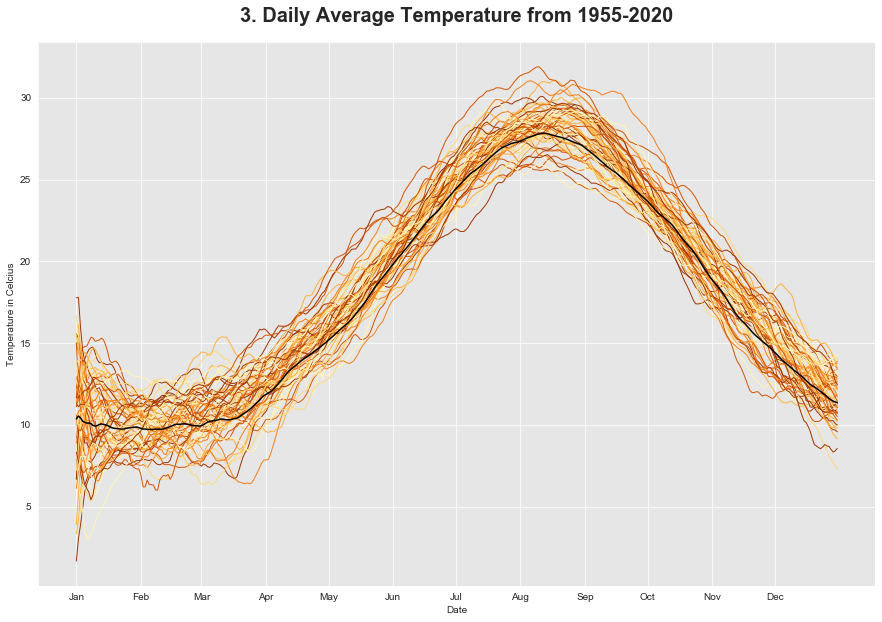

In [35]:

# Plot the graph
plt.figure(figsize=(15,10))
palette = itertools.cycle(sns.color_palette("YlOrBr"))
for year in temp['DATE'].dt.year.unique():
    # rolling average
    plot_daily = temp_pivot[year].rolling(30, min_periods=1).mean()

    # Generate the plots
    sns.lineplot(x=np.arange(0,366), y=plot_daily, color=next(palette), linewidth = 1)

# add baseline
sns.lineplot(x=np.arange(0,366), y=daily_temp['rolling'], color='black', linewidth = 1.5)

# xticks location
ticks = [0]
for month in range(1,13):
    ticks.append(monthrange(2020, month)[1])
ticks = np.cumsum(ticks)[:-1]

# Month names
month_names = [datetime.datetime.strptime(str(month_num), "%m").strftime("%b") for month_num in range(1,13)]


plt.ylabel('Temperature in Celcius')
plt.xlabel('Date')
plt.xticks(ticks, month_names)
plt.title('3. Daily Average Temperature from 1955-2020', 
            fontdict=font_dict,
            fontsize=20, 
            pad=20)
plt.show()

## Analysis: Interpretation of the graph

In the previous graph the light orange lines correspond to earlier dates (starting from 1995) while the darker ones to dates closer to the current one. Finally the Black line is the Average daily Temperature for dates between 1974 and 1999. All lines are smoothed using a 30 day rolling avg.<br>
We observe that during the summer period, the black line sits below most the the orange ones and by observing more carefully we may conclude that the lines above the baseline are mostly dark ones. That means that during the summer period the temperature is higher, which was observed in the previous section as well.<br>
What is interesting is that the situation is slightly different in the winter and early spring. The difference there does not follow the summer pattern since the baseline sits somewhere in the middle of all observations.


<br><br>

# Section 4: Extreme Temperature Events
Another mesure used by climatologists is the number of extreme events. Extreme events are defined as those beyond 5% or 10% from the expected value. We will deal with extreme heat events going 10% above the baseline.

We will count the number of extreme temperature events per year, compared to the baseline of 1974-1999. We should should produce a graph like the one that follows. The vertical axis is the percentage of extreme heat events calculated over the number of observations for each year. The gray line in the middle is the average percentage of extreme tempearture events of the baseline. The colour blue is used for those years where the percentage is below the baseline; otherwise the colour is orange. 

In [36]:
#add the baseline calculations to the pivot table
col = [i for i in range(1974,2000)]
temp_pivot['baseline'] = temp_pivot[col].mean(axis=1)
temp_pivot.head()

DATE       1957       1958       1961       1962       1963       1964  \
Month Day                                                                
1     1     NaN  12.222222  12.222222  12.777778  15.000000   9.444444   
      2     NaN  11.666667  12.222222  13.888889  13.888889   9.444444   
      3     NaN  12.222222  13.333333  16.666667  13.333333   7.777778   
      4     NaN  10.555556  13.888889  11.666667  16.666667  10.555556   
      5     NaN   8.333333  15.555556   8.888889  15.000000   8.888889   

DATE            1965       1966       1967       1968  ...       2012  2013  \
Month Day                                              ...                    
1     1    11.111111  13.333333  11.666667  15.000000  ...  10.000000  11.3   
      2    11.666667  12.222222  11.111111  15.000000  ...   9.444444  10.9   
      3    14.444444  13.333333  13.333333  14.444444  ...   9.444444  11.6   
      4    15.000000  12.777778  15.000000  11.666667  ...  11.111111  11.2   
      5    11.666667   7.222222  13.888889   9.444444  ...  11.111111  11.3   

DATE       2014       2015       2016       2017       2018      2019  \
Month Day                                                               
1     1     9.8   4.444444   3.888889   6.111111  11.111111  8.333333   
      2    11.3   4.444444   7.777778   8.333333  13.888889  7.222222   
      3    11.1   5.555556  11.666667  11.111111  11.666667  6.666667   
      4    10.8  11.111111  13.333333  11.666667   9.444444  5.555556   
      5    11.8   6.111111  17.222222  13.333333  10.555556  3.888889   

DATE           2020   baseline  
Month Day                       
1     1         NaN  10.363248  
      2    7.222222  10.705128  
      3    8.888889  10.213675  
      4         NaN   9.594017  
      5         NaN   9.957265  

[5 rows x 62 columns]

* We will start by calculating the average percentage of extreme events for the baseline. The calculation is performed as follows:
1. Since we have calculated the average temp for each day for the years 1974-1999, we will proceed by comparing each year's daily temperatures to that of the baseline. 
2. We will keep track of how many overvations are above the daily threshold (expected value) and then divide by the total number of observations.

In [37]:
# average percentage of extreme tempearture events of the baseline
num_extreme = 0
num_observation = 0
for column in col:
    num_extreme += temp_pivot.apply(lambda row: 1 if row[column] >= row['baseline'] * 1.1 and not(np.isnan(row[column])) else 0, axis=1).sum()
    num_observation += temp.loc[temp['DATE'].dt.year == column].shape[0]
baseline_extreme = num_extreme/num_observation
print(f"The average percentage of extreme events for the period of 1974-1999 is: {baseline_extreme:.3f}")

The average percentage of extreme events for the period of 1974-1999 is: 0.248


* Now that we have calculated the average percetage of the baseline, we can extend the calculation for each year.

In [38]:
# Calculate the average number of extreme events per year
extreme = {}
num_extreme = 0
num_observation = 0
for col in temp['DATE'].dt.year.unique():
    num_extreme = temp_pivot.apply(lambda row: 1 if row[col] >= row['baseline'] * 1.1 and not(np.isnan(row[col])) else 0, axis=1).sum()
    num_observation = temp.loc[temp['DATE'].dt.year == column].shape[0]
    extreme[col] = num_extreme/num_observation

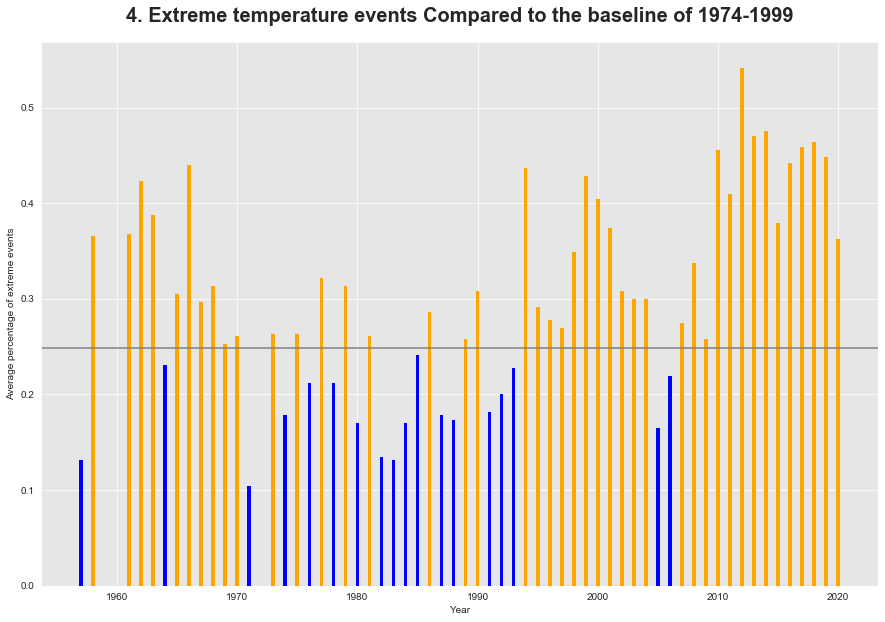

In [39]:
# define the colors
colors = ['orange' if value >= baseline_extreme else 'Blue' for key, value in extreme.items()]

# plot the figure
plt.figure(figsize=(15,10))
plt.bar(extreme.keys(), extreme.values(), width=0.3, color= colors, linewidth=0)
plt.axhline(baseline_extreme, color="gray")

plt.ylabel('Average percentage of extreme events')
plt.xlabel('Year')
plt.title('4. Extreme temperature events Compared to the baseline of 1974-1999', 
            fontdict=font_dict,
            fontsize=20, 
            pad=20)
_ = plt.show()

## Analysis: Interpretation of the graph

Regarding the extreme events, the observations we made in the previous sections are reinforced. <br>
The percentage of extreme events is steadily increasing and moving further away from the baseline we have defined. It is clear that not only higher average temperatures are observed the past years, but also the number of outliers is growing. 


<br><br>

# Section 5: Precipitation
Continuing the thread on extreme events, another consideration is rainfall. The weather may or may not be drying up. We are, however, interested in whether precipication becomes more intense over time.

To see that, we will count the overall rainfall over the year and the number of rainy days in each year. Then, by dividing the rainfall by the number of rainy days we will get an indication of whether we are getting rain in more concentrated bursts. We will then create a plot showing the ratio of rainfall over rainy days over the years. On the plot you will overlay the 10 years rolling average. What is your interpretation of the plot?

* Let's go back to our original dataframe, the merged one: 

In [40]:
# Check the original data with the precipitaion added. 
merged.head()

,STATION,NAME,DATE,PRCP,TAVG,TMAX,TMIN
0,GR000016716,"HELLINIKON, GR",1955-01-01,0.000,NaN,18.333333,10.000000
1,GR000016716,"HELLINIKON, GR",1955-01-02,2.032,NaN,14.444444,7.222222
2,GR000016716,"HELLINIKON, GR",1955-01-03,0.000,NaN,15.555556,9.444444
3,GR000016716,"HELLINIKON, GR",1955-01-04,0.000,NaN,18.888889,7.222222
4,GR000016716,"HELLINIKON, GR",1955-01-05,0.000,NaN,17.777778,8.333333


In [41]:
# drop any rows with missing data, as well as the temperature ones
perc = merged.drop(['STATION', 'NAME', 'TAVG', 'TMAX', 'TMIN'], axis=1).dropna()
perc.head()

,DATE,PRCP
0,1955-01-01,0.000
1,1955-01-02,2.032
2,1955-01-03,0.000
3,1955-01-04,0.000
4,1955-01-05,0.000


In [42]:
# Calculate the total percipitation, the count as well as the number of records with positive values
perc_grouped = perc.groupby(perc['DATE'].dt.year).agg(['count', 'sum', lambda x: x[x>0].count()]).reset_index()
perc_grouped['rain'] = perc_grouped['PRCP']['sum']/perc_grouped['PRCP']['<lambda_0>']
perc_grouped['rolling_rain'] = perc_grouped['rain'].rolling(10, min_periods=1).mean()
perc_grouped

DATE  PRCP                          rain rolling_rain
         count      sum <lambda_0>                       
0   1955   365  547.370       67.0  8.169701     8.169701
1   1956   366  281.432       50.0  5.628640     6.899171
2   1957   365  302.514       66.0  4.583545     6.127296
3   1958   365  350.266       65.0  5.388708     5.942649
4   1959   365  213.868       57.0  3.752070     5.504533
..   ...   ...      ...        ...       ...          ...
61  2016   366  261.332       42.0  6.222190     6.555773
62  2017   365  304.396       48.0  6.341583     6.634062
63  2018   365  380.422       55.0  6.916764     6.780416
64  2019   365  570.230       58.0  9.831552     7.226952
65  2020   338  210.312       38.0  5.534526     7.052938

[66 rows x 6 columns]

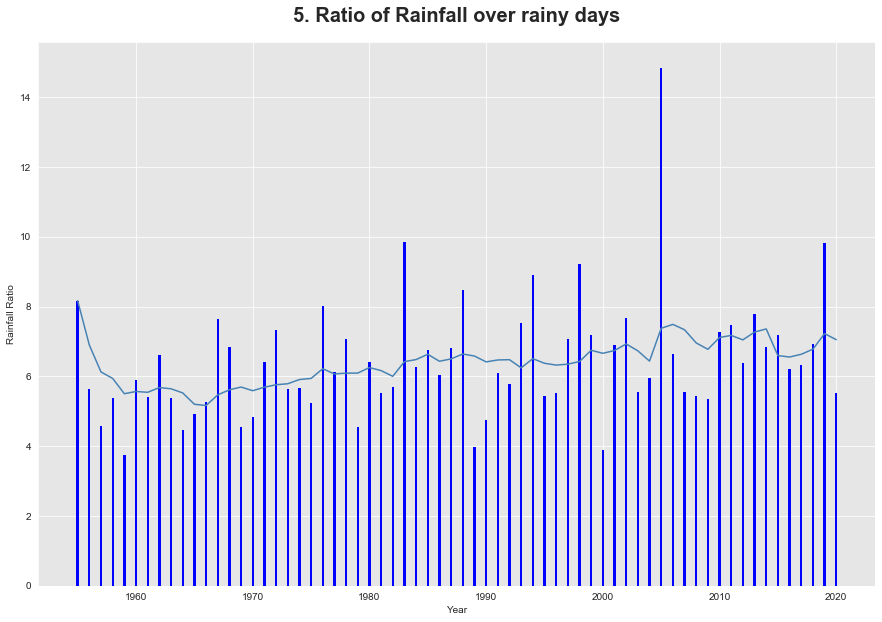

In [43]:
# plot the figure
plt.figure(figsize=(15,10))
plt.bar(perc_grouped['DATE'], perc_grouped['rain'], width=0.2, color= 'Blue', linewidth=0)
plt.plot(perc_grouped['DATE'], perc_grouped['rolling_rain'], color="steelblue")

plt.ylabel('Rainfall Ratio')
plt.xlabel('Year')
plt.title('5. Ratio of Rainfall over rainy days', 
            fontdict=font_dict,
            fontsize=20, 
            pad=20)
_ = plt.show()

## Analysis: Interpretation of the graph

Looking at the graph we can see that there is some kind of periodicity in the the rainfall ratio over rainy days. Over the years, after a peak, there would be years with less concentrated rain.<br>
The biggest difference can be seen in the last two decades, where the patter seems to break. On average the rainfall is more concentrated, which means that there are less days of rain. Looking at the rollowing average line, we can also see that the line is trending upwards.
